In [1]:
# Defaults
REGION = 'fortportal'
UTM = 32636
PIPELINE = 'output'
POP = 'grid_population'

In [2]:
# Parameters
REGION = "fortportal"
UTM = 32636
POP = "grid_population"
PIPELINE = "query"


In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime as dt
from pathlib import Path

plt.style.use('fivethirtyeight')
%matplotlib inline

In [4]:
CWD = Path('.')
DATA = Path('data')

INTER  = DATA/'inter'
INPUT  = DATA/'input'
OUTPUT = DATA/'output'

In [5]:
!ls {DATA}

input  inter  output  output.zip


In [6]:
!ls {OUTPUT} | grep {REGION}

fortportal_agglomerative.geojson
fortportal_grids_output_4326.geojson
fortportal_kmeans.geojson
fortportal_moran.geojson


In [7]:
grids_gdf = gpd.read_file(f'{OUTPUT}/{REGION}_grids_output_{4326}.geojson').to_crs(epsg=UTM)
region = gpd.read_file(f'{INPUT/REGION}.geojson').to_crs(grids_gdf.crs)

In [8]:
region.crs, grids_gdf.crs

(<Projected CRS: EPSG:32636>
 Name: WGS 84 / UTM zone 36N
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: World - N hemisphere - 30°E to 36°E - by country
 - bounds: (30.0, 0.0, 36.0, 84.0)
 Coordinate Operation:
 - name: UTM zone 36N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich,
 <Projected CRS: EPSG:32636>
 Name: WGS 84 / UTM zone 36N
 Axis Info [cartesian]:
 - E[east]: Easting (metre)
 - N[north]: Northing (metre)
 Area of Use:
 - name: World - N hemisphere - 30°E to 36°E - by country
 - bounds: (30.0, 0.0, 36.0, 84.0)
 Coordinate Operation:
 - name: UTM zone 36N
 - method: Transverse Mercator
 Datum: World Geodetic System 1984
 - Ellipsoid: WGS 84
 - Prime Meridian: Greenwich)

In [9]:
def show(region, gdf, col):
    fig, ax = plt.subplots(1,1,figsize=(10, 10))
    ax.set_axis_off()
    
    gdf.plot(ax=ax, cmap='RdYlGn_r', alpha=0.8, column=col, scheme='percentiles', legend=True)
    region.boundary.plot(ax=ax, color='darkgray', alpha=0.8)

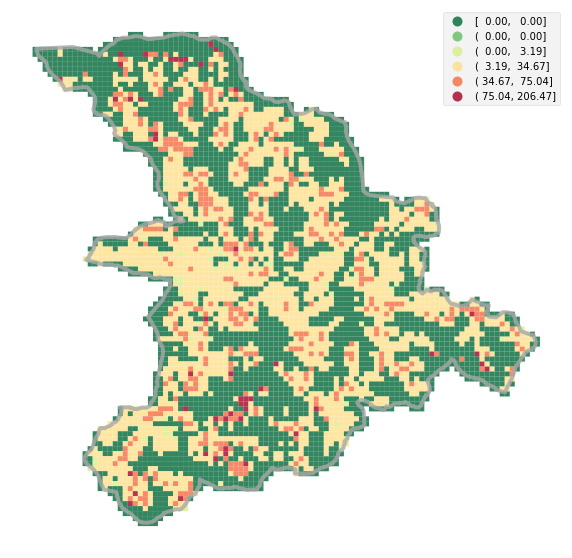

In [10]:
show(region, grids_gdf, POP)

### Analyse the population count data

<AxesSubplot:ylabel='Frequency'>

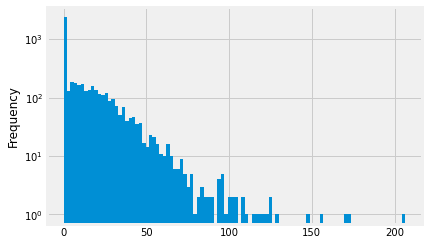

In [11]:
grids_gdf.grid_population.plot(kind='hist', bins=100, logy=True)

In [12]:
def _population(gdf, col, percentage=None, cutoff=None, top=True):
    total_pop = gdf[col].sum()
    gdf = gdf.sort_values(by=col, ascending=False)
    gdf["pop_percentile"] = (gdf[col].cumsum() / total_pop * 100).astype(np.float32)

    if percentage:
        if top:
            gdf = gdf.query("pop_percentile <= @percentage")
        else:
            gdf = gdf.query("pop_percentile > (100 - @percentage)")

    if cutoff:
        if top:
            gdf = gdf.query(f"{col} >= @cutoff")
        else:
            gdf = gdf.query(f"{col} <  @cutoff")
            
    return gdf[['idx', 'geometry', 'grid_population']]

In [13]:
population = _population(grids_gdf, POP, percentage=50)

In [14]:
population.shape

(593, 3)

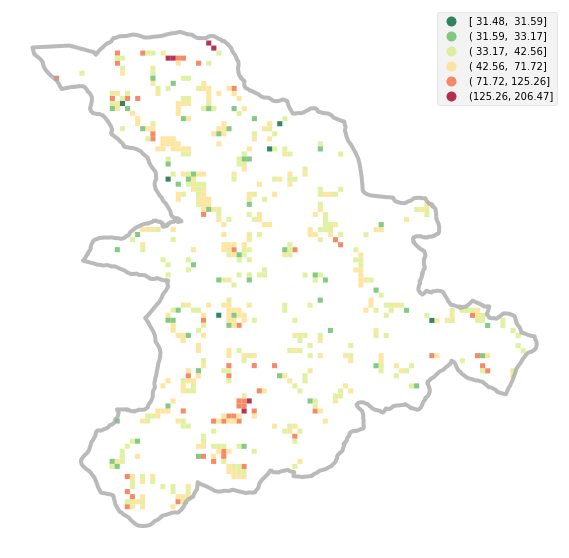

In [15]:
show(region, _population(grids_gdf, POP, percentage=50), POP)

In [16]:
def _building(gdf, metrics='area'):
    return gdf[['idx', 'geometry', f'grid_building_{metrics}']]

In [17]:
building = _building(grids_gdf, metrics='count')

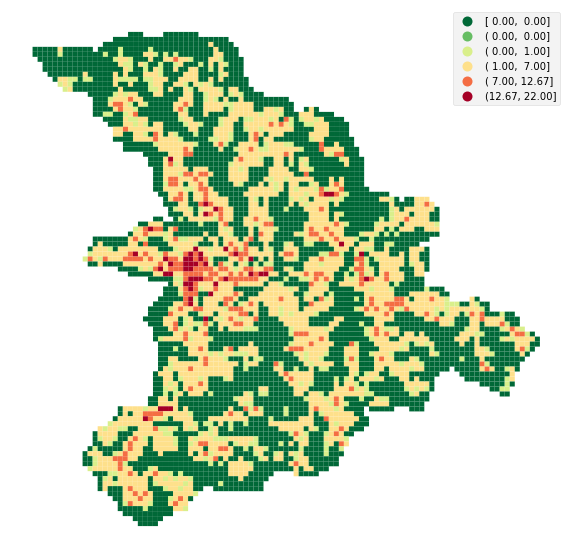

In [18]:
building.plot(figsize=(10, 10), cmap='RdYlGn_r', column='grid_building_count', scheme='percentiles', legend=True)
plt.gca().set_axis_off()

In [19]:
def _pairings(gdf):
    step_stats = list()
    for step in list(range(5, 100, 5)) + [99, 100]:
        per_df = _population(gdf, POP, percentage=step)
        step_stats.append(
            {
                "per": step,
                "pop": per_df[POP].sum(),
                "area": per_df.geometry.area.sum() / 1000000,
                "unit": "sq. km",
            }
        )

    return step_stats

In [20]:
pairings = pd.DataFrame(_pairings(grids_gdf))

In [21]:
(pairings
    .style
    .bar(subset='area'))

,per,pop,area,unit
0,5,2863.540250,0.196887,sq. km
1,10,5859.256067,0.505054,sq. km
2,15,8767.793251,0.881696,sq. km
3,20,11713.763519,1.318253,sq. km
4,25,14649.238302,1.806180,sq. km
5,30,17591.426958,2.354025,sq. km
6,35,20546.927056,2.953213,sq. km
7,40,23504.733369,3.603777,sq. km
8,45,26445.123928,4.305697,sq. km
9,50,29388.038628,5.076093,sq. km


<AxesSubplot:xlabel='per', ylabel='area'>

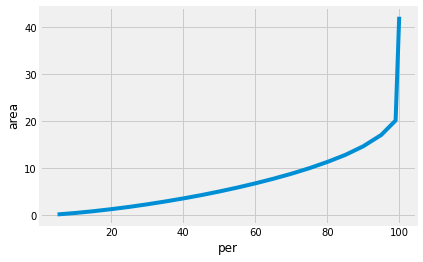

In [22]:
sns.lineplot(x=pairings.per, y=pairings.area)

In [23]:
def _stats(gdf):
    m2km = 1000000
    return {
        "area": f"{gdf.geometry.area.sum() / m2km:.2f} sq. km",
        "pop": f"{gdf[POP].sum():,.0f}",
        "release_area": f'{gdf.query(f"{POP} > 0").geometry.area.sum() / m2km:.2f} sq. km',
        "exclusion_area": f'{gdf.query(f"{POP} <= 0").geometry.area.sum() / m2km:.2f} sq. km',
        "analysis_date": dt.now().strftime("%Y-%m-%d %I-%M-%S %p"),
        "pop_stats": {
            "min": f"{gdf[POP].min():,.2f}",
            "max": f"{gdf[POP].max():,.2f}",
            "mean": f"{gdf[POP].mean():,.2f}",
            "median": f"{gdf[POP].median():,.2f}",
        },
        "building_stats": {
            "min_area": f"{gdf.grid_building_area.min()  } sq. m",
            "max_area": f"{gdf.grid_building_area.max()  } sq. m",
            "mean_area": f"{gdf.grid_building_area.mean() } sq. m",
            "min_count": f"{gdf.grid_building_count.min() }",
            "max_count": f"{gdf.grid_building_count.max() }",
            "mean_count": f"{int(gdf.grid_building_count.mean())}",
        },
    }

In [24]:
stats = _stats(grids_gdf)

In [25]:
stats

{'area': '42.24 sq. km',
 'pop': '58,784',
 'release_area': '21.68 sq. km',
 'exclusion_area': '20.55 sq. km',
 'analysis_date': '2020-11-07 01-39-58 PM',
 'pop_stats': {'min': '0.00',
  'max': '206.47',
  'mean': '11.91',
  'median': '3.19'},
 'building_stats': {'min_area': '0.0 sq. m',
  'max_area': '6045.009063141765 sq. m',
  'mean_area': '251.60038791695703 sq. m',
  'min_count': '0',
  'max_count': '22',
  'mean_count': '2'}}